<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/HIDS_ADFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Processing data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix

from sklearn.model_selection import train_test_split
%matplotlib inline

DATA = 'ADFA-LD'

import nltk
nltk.download("popular")

In [23]:
# Load data and unzip them
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true'
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Attack_Data_Master.zip?raw=true'


--2021-10-08 05:51:22--  https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-10-08 05:51:23--  https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-10-08 05:51:23--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [24]:
# Rename files
! mv Attack_Data_Master.zip?raw=true   Attack_Data_Master.zip
! mv Training_Data_Master.zip?raw=true Training_Data_Master.zip

# Unzip files
! unzip Training_Data_Master.zip
! unzip Attack_Data_Master.zip

Archive:  Training_Data_Master.zip
replace Training_Data_Master/UTD-0001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A n
  inflating: Training_Data_Master/UTD-0001.txt  
  inflating: Training_Data_Master/UTD-0002.txt  
  inflating: Training_Data_Master/UTD-0003.txt  
  inflating: Training_Data_Master/UTD-0004.txt  
  inflating: Training_Data_Master/UTD-0005.txt  
  inflating: Training_Data_Master/UTD-0006.txt  
  inflating: Training_Data_Master/UTD-0007.txt  
  inflating: Training_Data_Master/UTD-0008.txt  
  inflating: Training_Data_Master/UTD-0009.txt  
  inflating: Training_Data_Master/UTD-0010.txt  
  inflating: Training_Data_Master/UTD-0011.txt  
  inflating: Training_Data_Master/UTD-0012.txt  
  inflating: Training_Data_Master/UTD-0013.txt  
  inflating: Training_Data_Master/UTD-0014.txt  
  inflating: Training_Data_Master/UTD-0015.txt  
  inflating: Training_Data_Master/UTD-0016.txt  
  inflating: Training_Data_Master/UTD-0017.txt  
  inflating: Training_Data_Master/UTD-0018.txt 

**Syscall sequences in ADFA-LD are organized by folder, so we assume that they are already grouped by PID**

In [25]:
from glob import glob
import os
train_dir = 'Training_Data_Master/'
test_dir  = 'Attack_Data_Master/'

# Read data in a dataframe
def read_in_data(path, is_normal = 1): 
  lines = []
  if is_normal == 1:
    for filename in os.listdir(path): # iterate through all label folders in a directory 
      with open(path+filename) as f:
        lines.append(f.read())
       # data = pd.read_csv(path+filename, sep=' ', header=None)
       # list_of_dataframes.append(data.stack())
    
  else:
    for folder in os.listdir(path): # iterate through different attack folders in a directory
      files = glob(str(path + folder +"/*.txt"), recursive=False) # get a list of files from each label folder 
      for filename in files: 
        with open(filename) as f:
          lines.append(f.read())
        #data = pd.read_csv(filename, sep=' ', header=None)
        #lines.append(data.stack())

  df = pd.DataFrame(lines)
  #df = df.astype('int32')
  #df = pd.DataFrame(df)
  return df   

In [26]:
# Trainning set
train = read_in_data(train_dir)
train.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Normal training data size:', train.shape)
train.head(5)

Normal training data size: (833, 1)


,Syscall Sequence
0,6 91 5 197 192 6 174 174 174 174 174 174 174 1...
1,6 11 11 45 33 192 33 5 195 5 195 5 195 5 195 3...
2,311 240 240 180 180 180 180 180 180 180 180 18...
3,199 5 63 6 63 6 11 45 33 192 33 5 197 192 6 33...
4,174 6 6 5 220 221 221 221 221 221 221 221 221 ...


In [27]:
# Testing set
test = read_in_data(test_dir, is_normal = 0)
test.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Intrusion Testing data size:', test.shape)
test.head(5)

Intrusion Testing data size: (746, 1)


,Syscall Sequence
0,168 168 3 168 43 168 43 168 168 3 168 265 43 1...
1,240 78 265 78 240 78 240 265 240 240 265 240 2...
2,114 114 114 162 162 162 162 162 162 162 114 11...
3,3 168 168 3 265 168 265 168 146 168 3 265 168 ...
4,201 192 192 192 78 240 45 78 78 3 78 78 78 78 ...


## **EDA - Histogram of original data**



plt.figure(figsize=(20,6))
plt.hist(train['Syscall Sequence'], label='Normal', alpha=0.6, density=True)
plt.hist(test['Syscall Sequence'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [28]:
train.iloc[0]['Syscall Sequence']

'6 91 5 197 192 6 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 174 175 175 208 213 175 5 63 63 6 6 91 63 6 11 11 11 11 45 33 192 33 5 197 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 125 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 192 6 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 195 5 3 197 192 192 6 5 33 5 3 197 192 192 192 6 33 5 3 197 192 192 6 33 5 3 197 192 192 6 192 192 243 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 91 258 311 2

In [29]:
from nltk.tokenize import word_tokenize
from nltk import ngrams

## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid.index:
    token = word_tokenize(seq_per_pid.iloc[p]['Syscall Sequence'])  # Tokenize the string of sequence

    # Parse the sequence into length of 15
    sequences=sequences.append(list(nltk.ngrams(token,15)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(train)
print('Parsing Intrusion')
intrusion = parse_seq(test)
normal

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,6,91,5,197,192,6,174,174,174,174,174,174,174,174,174
1,91,5,197,192,6,174,174,174,174,174,174,174,174,174,174
2,5,197,192,6,174,174,174,174,174,174,174,174,174,174,174
3,197,192,6,174,174,174,174,174,174,174,174,174,174,174,174
4,192,6,174,174,174,174,174,174,174,174,174,174,174,174,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,180,180,180,180,180,180,180,180,180,180,180,240,240,240,240
290,180,180,180,180,180,180,180,180,180,180,240,240,240,240,240
291,180,180,180,180,180,180,180,180,180,240,240,240,240,240,240
292,180,180,180,180,180,180,180,180,240,240,240,240,240,240,78


In [30]:
intrusion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,168,168,3,168,43,168,43,168,168,3,168,265,43,168,265
1,168,3,168,43,168,43,168,168,3,168,265,43,168,265,168
2,3,168,43,168,43,168,168,3,168,265,43,168,265,168,168
3,168,43,168,43,168,168,3,168,265,43,168,265,168,168,265
4,43,168,43,168,168,3,168,265,43,168,265,168,168,265,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,78,78,78,4,78,240,4,4,240,4,4,240,78,4,240
113,78,78,4,78,240,4,4,240,4,4,240,78,4,240,240
114,78,4,78,240,4,4,240,4,4,240,78,4,240,240,240
115,4,78,240,4,4,240,4,4,240,78,4,240,240,240,13


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [31]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )

  c_intrusion = intrusion_set - normal_set
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

normal, intrusion = clean_data(normal, intrusion) # since train set contains only normal, it is passed in the func as normal. Similar to test

List sz vs. Set sz of normal sequences: 296415 vs. 131480
List sz vs. Set sz of intrusion sequences: 306944 vs. 259985
After cleaning: 
Normal sz: 131480  Intrusion sz: 259014


In [32]:
len(normal), len(intrusion)

(131480, 259014)

## **Histogram of Processed Data**

Text(0.5, 1.02, 'An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ADFA-LD')

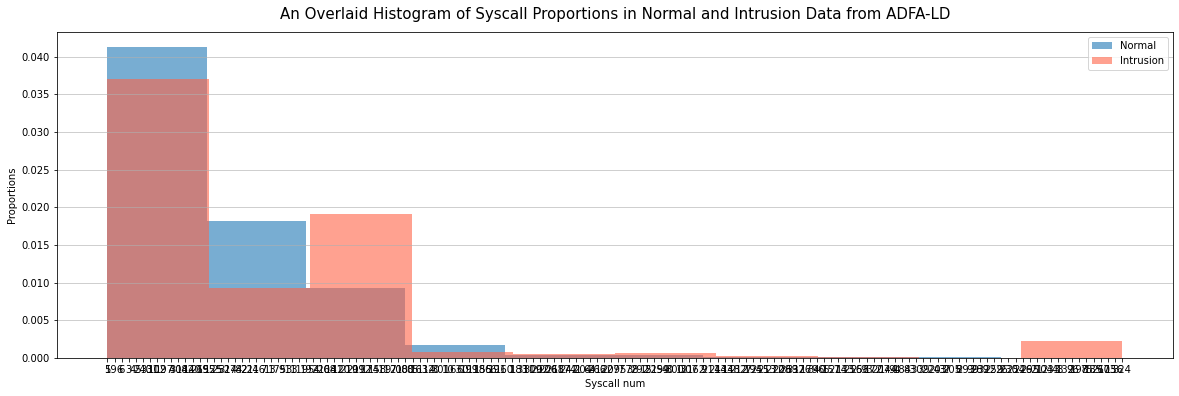

In [33]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [34]:
# Save cleaned train and test sets
normal.to_csv('normal.csv', index=False)
intrusion.to_csv('intrusion.csv', index=False)

**Labeling Sequences**

In [35]:
# Intrusion sequences is labeled 1.
intrusion['Label'] = 1
intrusion.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Label
0,168,265,168,168,265,43,3,265,43,265,3,265,43,265,43,1
1,265,265,240,4,240,4,13,4,78,4,4,78,78,13,4,1
2,168,168,168,78,78,78,168,78,78,168,168,168,168,168,168,1
3,168,265,3,43,3,265,43,168,265,265,43,168,3,168,265,1
4,168,265,265,168,265,265,3,265,3,168,3,168,168,265,3,1


In [36]:
# Normal sequences is labeled 0.
print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))
normal['Label'] = 0
normal.head(5)

Normal len: 131480 
Intrusion len: 259014


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Label
0,5,197,5,197,192,3,197,3,3,6,91,195,3,6,91,0
1,196,240,240,240,240,78,265,240,240,196,78,196,78,265,240,0
2,196,196,196,196,3,196,3,196,3,19,196,196,196,196,3,0
3,6,6,91,91,91,78,91,91,91,91,5,4,6,146,6,0
4,3,168,102,168,3,168,102,168,102,265,168,102,102,331,197,0


## **Partition Training and Testing dataset 70/30**

We do not need to bootstrap since there are more than enough data from both classes.

In [37]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (390494, 16)
Train sz: 273345 273345
Train set: Intrusion vs. Normal cases 181320 92025
Test sz: 117149 117149
Test set: Intrusion vs. Normal cases 77694 39455


In [38]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,265,265,104,142,3,104,146,175,3,142,142,265,104,175,265
1,6,78,142,78,78,78,142,142,142,142,102,13,78,195,142
2,168,265,3,265,168,265,168,265,265,265,265,265,3,3,168
3,6,6,3,6,3,6,5,3,6,3,6,3,6,3,6
4,3,43,168,168,168,168,43,168,265,265,168,3,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273340,142,7,3,4,140,140,120,3,221,5,42,120,142,7,142
273341,265,265,195,168,3,168,265,43,265,168,168,265,168,168,168
273342,195,3,42,54,140,54,140,120,6,6,3,196,10,37,5
273343,265,221,140,4,4,265,4,4,4,265,240,4,4,265,240


In [39]:
y_train

0         1
1         1
2         1
3         0
4         1
         ..
273340    0
273341    1
273342    0
273343    1
273344    1
Name: Label, Length: 273345, dtype: int64

In [40]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,195,5,221,91,195,5,221,197,91,195,5,221,197,192,6
1,146,142,265,142,265,3,3,142,142,146,142,265,265,142,119
2,265,265,265,168,265,168,168,168,168,168,168,102,265,168,168
3,3,142,175,146,3,3,3,3,175,146,3,146,3,119,265
4,3,6,91,6,195,3,6,91,195,3,192,3,6,91,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117144,3,5,5,3,3,3,3,3,3,3,3,3,3,3,3
117145,168,265,265,168,265,168,168,168,265,168,168,168,265,3,168
117146,125,125,91,5,3,192,192,5,192,6,91,5,192,192,5
117147,91,5,197,3,3,3,6,6,6,195,5,3,3,6,91



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [41]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance(model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  plt.title( model_name+' ROC Curve on ' + DATA)
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **K-means**

Confusion Matrix: 
 [[26375 13080]
 [23765 53929]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.69
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59     39455
           1       0.80      0.69      0.75     77694

    accuracy                           0.69    117149
   macro avg       0.67      0.68      0.67    117149
weighted avg       0.71      0.69      0.69    117149

AUC: 0.68


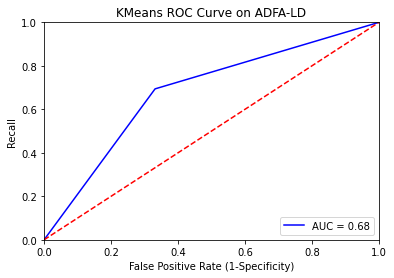

Number of iterations before converging: 5
Train AUC: 0.681 vs Test AUC: 0.681


In [42]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR for the TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING K-MEANS
y_predicted = kmeans.predict(x_test)

print_performance('KMeans',y_test, y_predicted)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)


# Recording TPR and FPR for the TESTING ROC curves
KM_test = {}
KM_test['fpr'], KM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KM_test['auc'] = roc_auc_score(y_test, y_predicted)


print('Train AUC: %.3f vs Test AUC: %.3f' %(KM_train['auc'], KM_test['auc']))

# **Logistic Regression**

Confusion Matrix: 
 [[14181 25274]
 [ 7065 70629]]

Testing Accuracy: 0.72
Precision:0.74
Recall: 0.91
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47     39455
           1       0.74      0.91      0.81     77694

    accuracy                           0.72    117149
   macro avg       0.70      0.63      0.64    117149
weighted avg       0.71      0.72      0.70    117149

AUC: 0.63


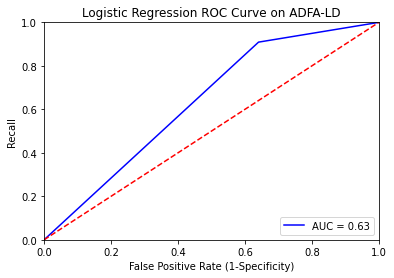

Train AUC: 0.634 vs Test AUC: 0.634


In [43]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set and predict the testing set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression
y_predicted = lgModel.predict(x_test)

# Evaluating Performance on Testing data
print_performance('Logistic Regression',y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
LR_test = {}
LR_test['fpr'], LR_test['tpr'], thresh = roc_curve(y_test, y_predicted)
LR_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(LR_train['auc'], LR_test['auc']))

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [44]:
# reduce data to train for SVM as it takes too long

train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = 0.1)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3,3,3,3,197,192,4,4,4,4,4,4,4,4,4
1,33,33,33,5,197,192,3,3,6,91,195,195,240,240,78
2,6,3,140,140,6,195,195,5,125,195,195,195,5,45,3
3,91,5,5,91,91,5,91,91,5,91,91,5,91,5,5
4,3,4,3,4,4,3,4,4,3,4,3,4,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27329,265,3,265,3,162,168,146,168,265,3,168,3,146,168,168
27330,3,142,3,175,104,3,175,104,142,3,3,142,3,142,3
27331,3,3,168,168,3,265,43,168,168,168,265,265,3,3,3
27332,175,142,3,142,3,3,142,3,3,175,142,3,3,3,265


In [45]:
svm_y_train

0        0
1        0
2        0
3        0
4        0
        ..
27329    1
27330    1
27331    1
27332    1
27333    1
Name: Label, Length: 27334, dtype: int64

In [46]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,265,265,104,142,3,104,146,175,3,142,142,265,104,175,265
1,6,78,142,78,78,78,142,142,142,142,102,13,78,195,142
2,168,265,3,265,168,265,168,265,265,265,265,265,3,3,168
3,6,6,3,6,3,6,5,3,6,3,6,3,6,3,6
4,3,43,168,168,168,168,43,168,265,265,168,3,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273340,142,7,3,4,140,140,120,3,221,5,42,120,142,7,142
273341,265,265,195,168,3,168,265,43,265,168,168,265,168,168,168
273342,195,3,42,54,140,54,140,120,6,6,3,196,10,37,5
273343,265,221,140,4,4,265,4,4,4,265,240,4,4,265,240



****Polynomial kernel model: 
[LibSVM]Confusion Matrix: 
 [[21404 18051]
 [16540 61154]]

Testing Accuracy: 0.70
Precision:0.77
Recall: 0.79
False Positive Rate: 0.46

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55     39455
           1       0.77      0.79      0.78     77694

    accuracy                           0.70    117149
   macro avg       0.67      0.66      0.67    117149
weighted avg       0.70      0.70      0.70    117149

AUC: 0.66


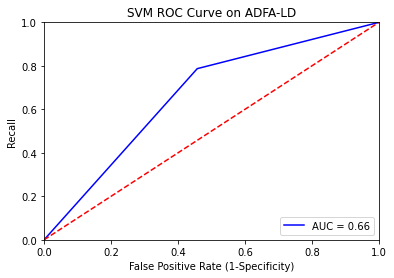

Train AUC: 0.676 vs Test AUC: 0.665


In [47]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly', verbose = True)

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


# Test the model w testing data
y_predicted = svm_model.predict(x_test)

# Evaluate the model 
print_performance('SVM', y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
SVM_test = {}
SVM_test['fpr'], SVM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
SVM_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(SVM_train['auc'], SVM_test['auc']))

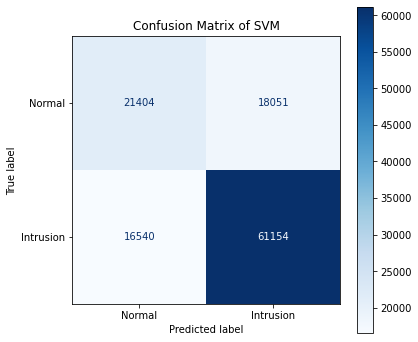

[[21404 18051]
 [16540 61154]]


In [48]:
# Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [49]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in ADFA-LD data is 325
max_syscall = 325
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [51]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),  # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size=128, verbose=1)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/10
2136/2136 [==============================] - 10s 3ms/step - loss: 0.5731 - accuracy: 0.7157
Epoch 2/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5622 - accuracy: 0.7266
Epoch 3/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5582 - accuracy: 0.7280
Epoch 4/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5541 - accuracy: 0.7296
Epoch 5/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5513 - accuracy: 0.7309
Epoch 6/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5493 - accuracy: 0.7317
Epoch 7/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5474 - accuracy: 0.7327
Epoch 8/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5458 - accuracy: 0.7335
Epoch 9/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.5436 - accuracy: 0.7346
Epoch 10/10
2136/2136 [==============================] - 7s 3ms/step - loss: 0.54

In [52]:
# Get predict Training classes
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)

3661/3661 [==============================] - 10s 3ms/step - loss: 0.5378 - accuracy: 0.7391
Test accuracy: 0.7391270995140076  Test loss: 0.537797212600708
Confusion Matrix: 
 [[16779 22676]
 [ 7885 69809]]

Testing Accuracy: 0.74
Precision:0.75
Recall: 0.90
False Positive Rate: 0.57

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.43      0.52     39455
           1       0.75      0.90      0.82     77694

    accuracy                           0.74    117149
   macro avg       0.72      0.66      0.67    117149
weighted avg       0.73      0.74      0.72    117149

AUC: 0.66


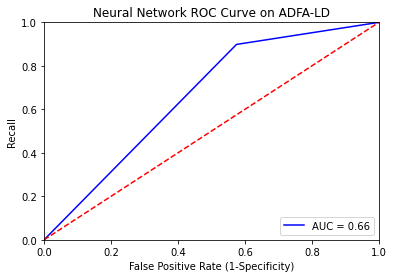

Train AUC: 0.661 vs Test AUC: 0.662


In [53]:
# Get the loss and accuracy on testing set
test_loss, test_acc = nn_model.evaluate(x_test_nn,  y_test, verbose=1) 
y_predicted = np.argmax(nn_model.predict(x_test_nn), axis=-1)


print('Test accuracy:', test_acc,' Test loss:', test_loss)
print_performance('Neural Network',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NN_test = {}
NN_test['fpr'], NN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NN_train['auc'], NN_test['auc']))

In [54]:
nn_model.summary()

#history.history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

Confusion Matrix: 
 [[31975  7480]
 [ 7535 70159]]

Testing Accuracy: 0.87
Precision:0.90
Recall: 0.90
False Positive Rate: 0.19

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     39455
           1       0.90      0.90      0.90     77694

    accuracy                           0.87    117149
   macro avg       0.86      0.86      0.86    117149
weighted avg       0.87      0.87      0.87    117149

AUC: 0.86


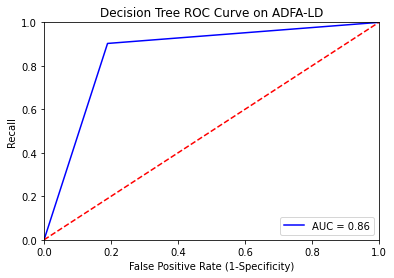

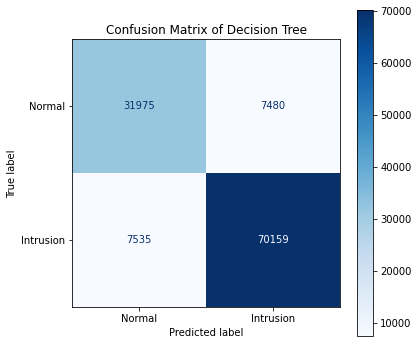

[[31975  7480]
 [ 7535 70159]]
Train AUC: 0.918 vs Test AUC: 0.857


In [55]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Decision Tree', decTree, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = {}
DT_test['fpr'], DT_test['tpr'], thresh = roc_curve(y_test, y_predicted)
DT_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(DT_train['auc'], DT_test['auc']))

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.




Confusion Matrix: 
 [[34758  4697]
 [ 4481 73213]]

Testing Accuracy: 0.92
Precision:0.94
Recall: 0.94
False Positive Rate: 0.12

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     39455
           1       0.94      0.94      0.94     77694

    accuracy                           0.92    117149
   macro avg       0.91      0.91      0.91    117149
weighted avg       0.92      0.92      0.92    117149

AUC: 0.91


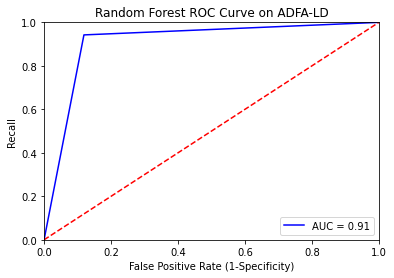

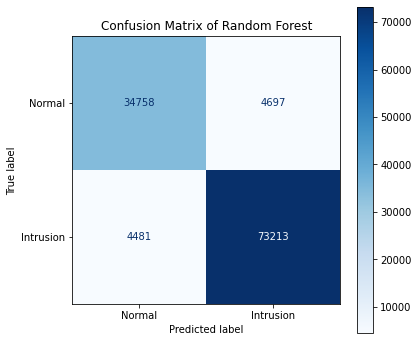

[[34758  4697]
 [ 4481 73213]]
Train AUC: 0.957 vs Test AUC: 0.912


In [56]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Random Forest', randomForest, x_test, y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
RF_test = {}
RF_test['fpr'], RF_test['tpr'], thresh = roc_curve(y_test, y_predicted)
RF_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(RF_train['auc'], RF_test['auc']))

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

Confusion Matrix: 
 [[29326 10129]
 [17195 60499]]

Testing Accuracy: 0.77
Precision:0.86
Recall: 0.78
False Positive Rate: 0.26

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     39455
           1       0.86      0.78      0.82     77694

    accuracy                           0.77    117149
   macro avg       0.74      0.76      0.75    117149
weighted avg       0.78      0.77      0.77    117149

AUC: 0.76


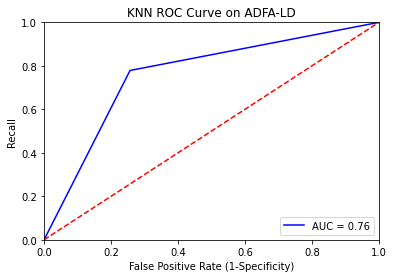

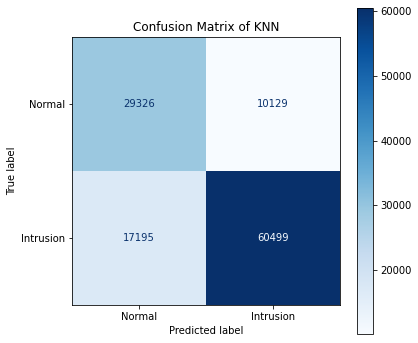

[[29326 10129]
 [17195 60499]]
Train AUC: 0.879 vs Test AUC: 0.761


In [57]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('KNN', KNN, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = {}
KNN_test['fpr'], KNN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KNN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(KNN_train['auc'], KNN_test['auc']))

# **Naive Bayes**

Confusion Matrix: 
 [[23930 15525]
 [19073 58621]]

Testing Accuracy: 0.70
Precision:0.79
Recall: 0.75
False Positive Rate: 0.39

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58     39455
           1       0.79      0.75      0.77     77694

    accuracy                           0.70    117149
   macro avg       0.67      0.68      0.68    117149
weighted avg       0.71      0.70      0.71    117149

AUC: 0.68


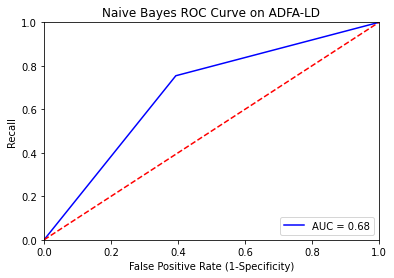

Train AUC: 0.679 vs Test AUC: 0.681


In [58]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = NaiveBayes.predict(x_test)

# Print performance measures
print_performance('Naive Bayes',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NB_test = {}
NB_test['fpr'], NB_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NB_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NB_train['auc'], NB_test['auc']))

# **BERT**


In [59]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 123 kB 5.2 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 131 kB 42.1 MB/s 
     |████████████████████████████████| 8.0 MB 38.6 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 39.8 MB/s 
     |████████████████████████████████| 127 kB 47.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [60]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [61]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts) 

train_labels = tuple(y_train.tolist())
test_labels = tuple(y_test.tolist())

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(273345, 273345, 117149, 117149)

In [62]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

100%|██████████| 231508/231508 [00:00<00:00, 2659724.64B/s]


['54',
 '309',
 '309',
 '3',
 '54',
 '54',
 '3',
 '309',
 '54',
 '54',
 '309',
 '54',
 '54',
 '54',
 '54']

In [63]:
# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )       

Number of Training Sequences: 273345 
Number of Testing Sequences: 117149


In [64]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((273345, 20), (117149, 20))

In [65]:
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((273345,), (117149,), 0.6633375404708336, 0.6632066855030773)

In [66]:
# To mask the paddings
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [67]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [69]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:11<00:00, 35011551.33B/s]


**Fine Tune BERT**

In [70]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks,2,256)

Epoch:  2
1067/1067.75390625 loss: 0.06258627929295717 


**Evaluate on Testing Set**

In [71]:
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

# Convert to tensro for maks
test_masks_tensor = torch.tensor(test_masks)

# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Defile test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [72]:
bert_clf.eval() # Define eval
bert_predicted = [] # To Store predicted result
all_logits = [] # Actual output that is between 0 to 1 is stored here
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

Confusion Matrix: 
 [[38010  1445]
 [  744 76950]]

Testing Accuracy: 0.98
Precision:0.98
Recall: 0.99
False Positive Rate: 0.04

Classification report:
              precision    recall  f1-score   support

       False       0.98      0.96      0.97     39455
        True       0.98      0.99      0.99     77694

    accuracy                           0.98    117149
   macro avg       0.98      0.98      0.98    117149
weighted avg       0.98      0.98      0.98    117149

AUC: 0.98


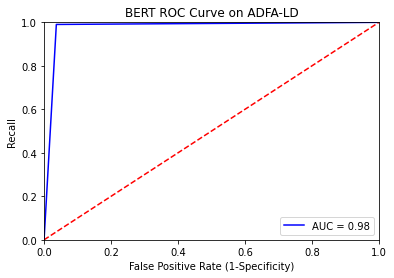

In [73]:
print_performance('BERT',test_y, bert_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
BERT_test = {}
BERT_test['fpr'], BERT_test['tpr'], thresh = roc_curve(test_y, bert_predicted)
BERT_test['auc'] = roc_auc_score(test_y, bert_predicted)

# **GPT-2**

In [74]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 49.3 MB/s 
     |████████████████████████████████| 636 kB 43.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [75]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

In [76]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)

In [77]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

(torch.Size([273345, 15]), torch.Size([117149, 15]))

In [78]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [79]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [80]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks,2,256)

Epoch:  2
1067/1067.75390625 loss: 0.08747601150692011 


**Evaluate on Testing Set**

In [82]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [83]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

Confusion Matrix: 
 [[37972  1483]
 [ 1408 76286]]

Testing Accuracy: 0.98
Precision:0.98
Recall: 0.98
False Positive Rate: 0.04

Classification report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96     39455
        True       0.98      0.98      0.98     77694

    accuracy                           0.98    117149
   macro avg       0.97      0.97      0.97    117149
weighted avg       0.98      0.98      0.98    117149

AUC: 0.97


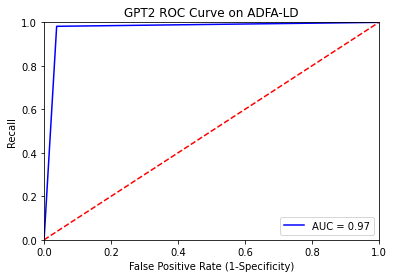

In [84]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 

# **Graphing multi-ROC Curves**

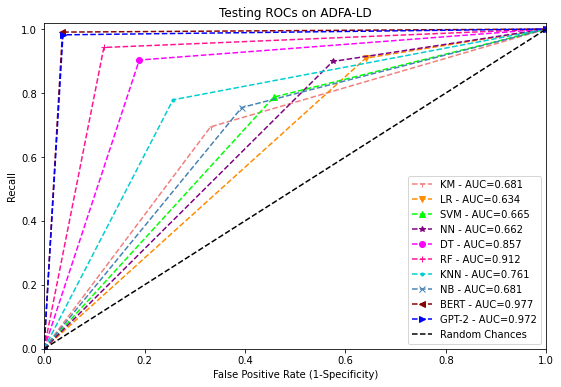

In [85]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()